In [1]:
!pip3 install pypolyagamma

     |████████████████████████████████| 235kB 14.0MB/s 
  Created wheel for pypolyagamma: filename=pypolyagamma-1.2.2-cp36-cp36m-linux_x86_64.whl size=577212 sha256=53641e622d317299f8acdccaed1c5bf019d7a691821b4271876c0a16df6be483
  Stored in directory: /root/.cache/pip/wheels/ff/b4/34/046d7d99529aa5fe3ab7755a0a37885e6c0d1bdc601c146bf0
Successfully built pypolyagamma


In [0]:
from pypolyagamma import PyPolyaGamma

In [4]:
!git clone https://github.com/slinderman/ssm.git
%cd ssm
!pip install -e .

Cloning into 'ssm'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2139 (delta 73), reused 80 (delta 42), pack-reused 2016
Receiving objects: 100% (2139/2139), 16.47 MiB | 31.71 MiB/s, done.
Resolving deltas: 100% (1466/1466), done.
/content/ssm
Obtaining file:///content/ssm
  Running setup.py develop for ssm


In [0]:
from ssm import messages

In [0]:
import numpy as np
import numpy.random as npr
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as MVN
import sys

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

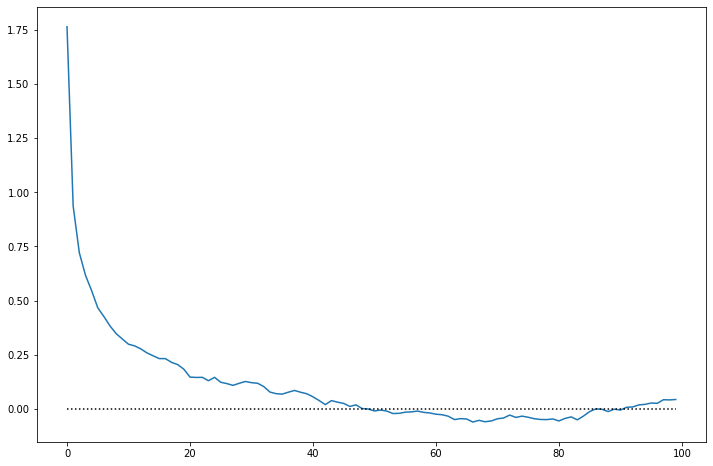

In [6]:
npr.seed(0)
N = 1
T = 100
dt = 1.0
# W = npr.randn(N, N) / (10 * N)
# B = npr.randn(N, 1)
# u = 0.1 * npr.randn(T, 1)
W = np.array([[0.95]])
B = np.zeros((N, 1))
u = np.zeros((T, 1))
x0 = npr.randn(N)
sigma = 0.01

# Sample the vanilla RNN
x = np.zeros((T, N))
x[0] = x0
for t in range(1, T):
    x[t] = np.tanh(W @ x[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)

plt.figure(figsize=(12, 8))
plt.plot(x + 2 * np.arange(N))
for n in range(N):
    plt.plot(2 * n * np.ones(T), ":k")

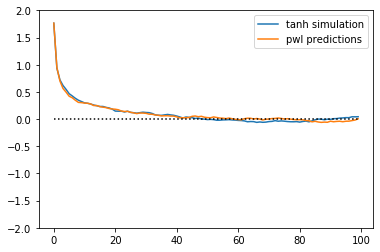

In [8]:
# Sample the vanilla RNN
pwl_tanh = PiecewiseLinearTanh(num_parts=16)
xpred = np.zeros((T, N))
xpred[0] = x0
for t in range(1, T):
    xpred[t] = pwl_tanh.f(W @ xpred[t-1] + B @ u[t]) + np.sqrt(dt) * sigma * npr.randn(N)

plt.plot(x, label="tanh simulation")
plt.plot(xpred, label='pwl predictions')
plt.ylim(-2, 2)
plt.plot(np.zeros(T), ":k")
plt.legend(loc="upper right")

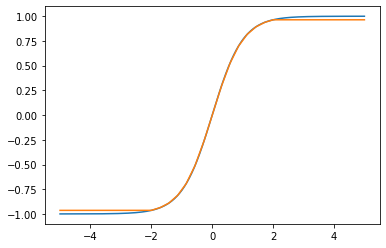

In [9]:
xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.tanh(xx))
plt.plot(xx, pwl_tanh.f(xx))

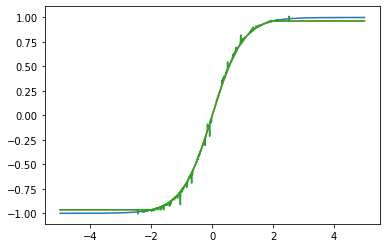

In [11]:
pwl_tanh = PiecewiseLinearTanh()
spwl_tanh = StochPiecewiseLinearTanh(num_parts=16, temp=0.25)

xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.tanh(xx))
plt.plot(xx, pwl_tanh.f(xx))
plt.plot(xx, spwl_tanh.f(xx))

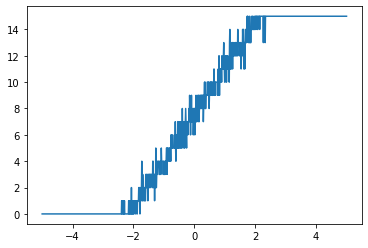

In [12]:
plt.plot(xx, spwl_tanh.f(xx, return_z=True)[1])

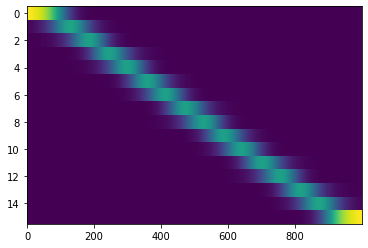

In [13]:
plt.imshow(spwl_tanh.discrete_prior(xx).T, aspect="auto")

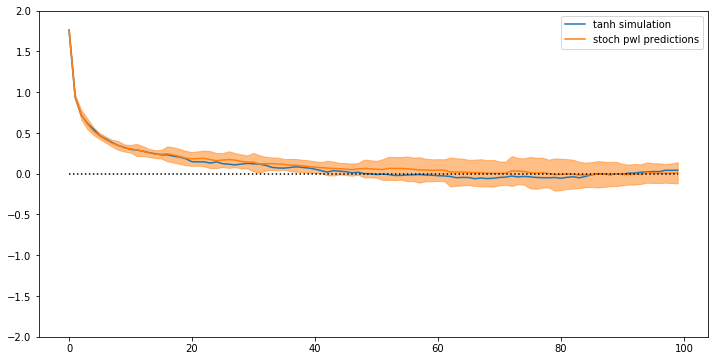

In [14]:
# Sample the stochastic pwl tanh RNN
n_samples = 10
xpreds = np.zeros((n_samples, T, 1))
zpreds = np.zeros((n_samples, T), dtype=int)
for n in range(n_samples):
  xpreds[n, 0] = x0
  for t in range(1, T):
      # yhat, zpreds[n, t] = spwl_tanh.f(w * xpreds[n, t-1] + b, return_z=True)
      mu_pred, zpreds[n, t] = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t], return_z=True)
      xpreds[n, t] = mu_pred + np.sqrt(dt) * sigma * npr.randn(N)

xpred_mean = np.mean(xpreds, axis=0)[:, 0]
xpred_std = np.std(xpreds, axis=0)[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(x, label="tanh simulation")
h = plt.plot(xpred_mean, label='stoch pwl predictions')[0]
plt.fill_between(np.arange(T), 
                 xpred_mean - 2 * xpred_std, 
                 xpred_mean + 2 * xpred_std,
                 color=h.get_color(),
                 alpha=0.5)

plt.ylim(-2, 2)
plt.plot(np.zeros(T), ":k")
plt.legend(loc="upper right")

In [0]:
spwl_tanh = StochPiecewiseLinearTanh()
zsmpls, msmpls, Vsmpls = spwl_tanh.resample(xpreds[0, :-1, 0], xpreds[0, 1:, 0], dt * sigma**2)

# # Combine the Gaussian potentials into one
# Jsmpls = 1 / Vsmpls
# hsmpls = msmpls / Vsmpls
# Jeff = Jsmpls.sum(axis=1)
# heff = hsmpls.sum(axis=1)
# meff = heff / Jeff
# Veff = 1 / Jeff

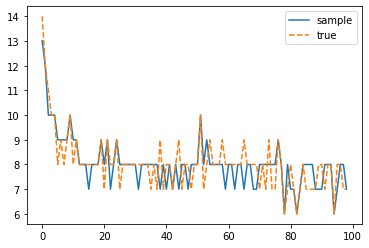

In [16]:
plt.plot(zsmpls, label="sample")
plt.plot(zpreds[0, 1:], '--', label="true")
plt.legend()

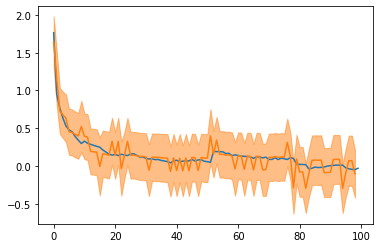

In [17]:
plt.plot(xpreds[0])
h = plt.plot(msmpls)[0]
plt.fill_between(np.arange(T-1), 
                 msmpls - 2 * np.sqrt(Vsmpls), 
                 msmpls + 2 * np.sqrt(Vsmpls),
                 color=h.get_color(),
                 alpha=0.5)

In [0]:
# Define the piecewise linear tanh approximation
class PiecewiseLinearSigmoid(object):
    """
    Piecewise linear approximation to sigma(x) with the specified 
    window size and number of linear parts.
    """
    def __init__(self, num_parts=16, window=4):
        self.num_parts = num_parts
        self.knots = np.linspace(-window, window, num_parts-1)
        self.values = sigmoid(self.knots)

        # Compute slopes and intercepts for each bin
        self.slopes = np.concatenate(([0], np.diff(self.values) / np.diff(self.knots), [0]))
        self.intercepts = np.concatenate(([self.values[0]], self.values - self.slopes[1:] * self.knots))

    def f(self, x):
        z = np.digitize(x, self.knots)
        return self.intercepts[z] + self.slopes[z] * x
        
class PiecewiseLinearTanh(PiecewiseLinearSigmoid):
    def f(self, x):
        return 2 * super(PiecewiseLinearTanh, self).f(2 * x) - 1



In [0]:
# Define the piecewise linear tanh approximation
class StochPiecewiseLinearSigmoid(PiecewiseLinearSigmoid):
    """
    Stochastic p.w.l. approximation to sigma(x) with the specified 
    window size and number of linear parts.  Here, the discrete
    part is chosen randomly based on a tree-structured stick breaking
    of the interval.
    """
    def __init__(self, num_parts=16, window=4, temp=0.25):
        super(StochPiecewiseLinearSigmoid, self).__init__(num_parts, window)
        self.temp = temp

        # Precompute the transition probabilities on a dense grid        
        # num_pts = 1000
        # x = np.linspace(-1.5 * window, 1.5 * window, num_pts)
        # p = np.ones((num_pts, num_parts))

        # Get length of binary representation (i.e. depth of tree)
        decimal, depth = np.modf(np.log2(num_parts))
        assert np.allclose(decimal, 0), "number of parts must be a power of 2."
        depth = int(depth)
        self.depth = depth

        # Get a binary representation of each of the discrete parts
        self._bs = np.unpackbits(
            np.arange(self.num_parts, 
                      dtype=np.uint8)[:, None], axis=1)[:, -(self.depth):]

        # Precompute indices of decision knots for each discrete state
        mids = 2**np.arange(self.depth - 1, -1, -1)
        lefts = np.column_stack((np.zeros(self.num_parts), 
                                 np.cumsum(self._bs[:, :-1] * mids[:-1], axis=1)))
        self._inds = np.array(lefts + mids - 1, dtype=int)

    
    def f_given_z(self, x, z):
      return self.intercepts[z] + self.slopes[z] * x
    
    def f(self, x, return_z=False):
        """
        Sample a discrete state given x, then return the corresponding
        linear function of x.
        """
        x = np.atleast_1d(x)
        z = np.zeros_like(x, dtype=int)
        shp = x.shape
        for d in range(self.depth):
            mid = 2**(self.depth-d-1) - 1
            choice = npr.rand(*shp) < sigmoid((x - self.knots[z + mid]) / self.temp)
            z += choice * (mid + 1)
        
        if return_z:
            return self.f_given_z(x,z), z
        else:
            return self.f_given_z(x,z)
        
        '''
        if return_z:
            return self.intercepts[z] + self.slopes[z] * x, z
        else:
            return self.intercepts[z] + self.slopes[z] * x
        '''

    def discrete_prior(self, x):
        """
        Get the prior on discrete states for input x
        """
        # Convert input to 1d arrays
        x = np.atleast_1d(x)
        assert x.ndim == 1
        N, = x.shape
        
        # To compute the posterior distribution of discrete states,
        # first evaluate sigmoids at each (input, knot) pair.
        s = sigmoid((x[:, None] - self.knots[None, :]) / self.temp)
        oms = 1 - s

        # Discrete state probabilities are products of sigmoids for subsets
        # of knots.
        prior = np.ones((N, self.num_parts))
        for k in range(self.num_parts):
            bk = self._bs[k]
            ik = self._inds[k]
            prior[:, k] = np.prod(s[:, ik[bk==1]], axis=1) * \
                          np.prod(oms[:, ik[bk==0]], axis=1)
        return prior

    def resample_discrete_states(self, x, y, sigmasq):
        """
        Sample discrete variable z given (input, output) pair (x, y) and 
        Gaussian noise variance sigmasq.
        """
        # Convert input to 1d arrays
        x = np.atleast_1d(x)
        N, = x.shape
        y = np.reshape(y, (N,))

        # Get the log prior on discrete states
        log_prior = np.log(self.discrete_prior(x))

        # Compute log likelihood (up to constant) under each discrete state
        yhat = x[:, None] * self.slopes + self.intercepts
        log_lkhd = -0.5 * (y[:, None] - yhat)**2 / sigmasq

        # Posterior is proportional to prior * lkhd
        log_post = log_prior + log_lkhd
        post = np.exp(log_post - logsumexp(log_post, axis=1, keepdims=True))

        self.cond_z = post ##for unit testing

        # Sample the posterior
        z = np.array([npr.choice(self.num_parts, p=pn) for pn in post])
        return z

    def resample_auxiliary_variables(self, x, z):
        # Sample the conditional distribution of the Polya-gamma auxiliary 
        # variable \omega given the input x.  Here the discrete state really
        # corresponds to a set of Bernoulli random variables.  Each one is 
        # parameterized as,
        #
        #     b_i ~ Bern(\sigma((x - \theta_i) / tau)) 
        # 
        # where \theta_i is the knot for the i-th choice.  The conditional
        # distribution is \omega ~ PG(1, (x - \theta_i) / tau)), and is 
        # independent of the binary outcome b_i. 
        b = self._bs[z]

        i = self._inds[z]
        u = (x[:, None] - self.knots[i]) / self.temp


        # Sample the auxiliary variable and compute the potential on u
        # TODO: Sample rather than just returning the mean
        #Ju = np.tanh(u / 2) / (2 * u)
        
        pg_shp = u.ravel().shape
        pg = PyPolyaGamma(seed=npr.randint(0,100000000))
        Ju = np.empty(pg_shp)        
        pg.pgdrawv(np.ones(pg_shp), u.ravel(), Ju)
        Ju = Ju.reshape(u.shape)
        
        hu = b - 0.5

        # Convert to mean parameters
        mu = hu / Ju
        Vu = 1 / Ju

        # Convert the potential on u to a potential on x.
        mx = mu * self.temp + self.knots[i]
        Vx = Vu * self.temp**2

        # Convert back to natural parameters, sum, and return mean
        Jx = np.sum(1 / Vx, axis=1)
        hx = np.sum(mx / Vx, axis = 1)
        mx = hx / Jx
        Vx = 1 / Jx
        return mx, Vx

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete state and auxiliary variables for given inputs (x) 
        and outputs (y), and given noise variance sigmasq. 
        """
        # First sample the discrete states
        zs = self.resample_discrete_states(x, y, sigmasq)
        bs = self._bs[zs]

        # Then sample auxiliary variables from conditional and compute the 
        # effective Gaussian observation potential.
        mx, Vx = self.resample_auxiliary_variables(x, zs)
        return zs, mx, Vx

            


class StochPiecewiseLinearTanh(StochPiecewiseLinearSigmoid):
    def f(self, x, return_z=False):
        if return_z:
            y, z = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1, z
        else:
            y = super(StochPiecewiseLinearTanh, self).f(2 * x, return_z)
            return 2 * y - 1

    def resample(self, x, y, sigmasq):
        """
        Resample the discrete states and auxiliary variables given observations
        of y = tanh(x) + N(0, sigmasq).  This is equivalent to,

            y' = sigmoid(x') + N(0, sigmasq')

        where y' = (y + 1) / 2
              x' = 2 * x
              sigmasq' = sigmasq / 4

        The output is a set of discrete state samples and Gaussian potentials
        on the input to the sigmoid, here p(z | x) ~ N(x' | mx', Vx'), which is
        equivalent to N(x | mx'/2, Vx'/4) 
        """
        zs, mx, Vx = super(StochPiecewiseLinearTanh, self).\
            resample(2 * x, (y + 1) / 2, sigmasq / 4)

        return zs, mx / 2, Vx / 4


    def x_recurrence_params(self, state, sigmasq):
      A = 4*self.slopes[state.z]*state.W[0,0]
      Bu_tilde = (state.B @ state.u[1:])[:,0,0]
      Bu = 4*self.slopes[state.z]*Bu_tilde +2*self.intercepts[state.z]-1

      
      J_ini = 1/sigmasq 
      J_ini = np.atleast_1d(J_ini)[:,None]

      J_dyn_11 = A[1:]*1/sigmasq*A[1:]

      J_dyn_21 = -A[1:]*1/sigmasq
      J_dyn_21 = J_dyn_21.reshape(-1,1,1)

      J_dyn_22 = 1/sigmasq    
      J_dyn_22 = np.atleast_1d(J_dyn_22)[:,None]

      h_ini = 1/sigmasq*(A[0]*state.x[0,0,0]+Bu[0])
      h_ini = np.atleast_1d(h_ini)

      h_dyn_1 = -Bu[1:]*1/sigmasq*A[1:]
      h_dyn_2 = Bu[1:]*1/sigmasq
      h_dyn_2 = h_dyn_2[:,None]

      return J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2

    def x_obs_params(self, state, sigmasq_y):
      J_obs = state.C[0,0]*1/sigmasq_y*state.C[0,0]
      h_obs = state.y[:,0,0]*1/sigmasq_y*state.C[0,0]
      J_obs = np.atleast_1d(np.ones(h_obs.shape)*J_obs).reshape(-1,1,1)
      h_obs = h_obs[:,None]
      return J_obs, h_obs

    def Wbar_recurrence_params(self, state, r, rrT, sigmasq):
      J = ((4*self.slopes[state.z][:,None,None])**2)*(1/sigmasq)*rrT      
      h = 1/sigmasq*4*self.slopes[state.z]*(state.x[1:,0,0]-(2*self.intercepts[state.z]-1))
      h = h[:,None,None]*r
      return J, h

    def gibbs_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights):
      
      # 1. Sample discrete states and auxiliary variables given continuous states x and Wbar.
      #First compute the input to the tanh
      inx = state.get_inx()[:,0,0]
      iny = state.x[1:,0,0]
      state.z, ms, Vs = spwl_tanh.resample(inx, iny, sigma**2)

      '''
      ###########################
      #z unit tests
      state.z, _, _ = spwl_tanh.resample(inx, iny, sigma**2)
      log_cond1 = np.sum(np.log(self.cond_z[np.arange(len(state.z)),state.z]))
      log_joint1 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)

      state.z, _, _ = spwl_tanh.resample(inx, iny, sigma**2)
      log_cond2 = np.sum(np.log(self.cond_z[np.arange(len(state.z)),state.z]))
      log_joint2 = self.log_joint_nopgs(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)

      print('z')
      print('log_joint1-log_joint2')
      print(log_joint1-log_joint2)
      print('log_cond1-log_cond2')
      print(log_cond1-log_cond2)
      sys.exit()
      ############################
      '''

      # 2. Sample continuous states x given (linear Gaussian) observations y and 
      #    current discrete states and auxiliary variables 

      #first Convert mean and variance on Wx + Bu to natural paramteters on x
      J_tildes = state.W[0,0] * 1/Vs[1:] * state.W[0,0]
      h_tildes = state.W[0,0]* 1/Vs[1:]*(ms[1:]- (state.B @ state.u[2:])[:,0,0]  )

      #Get recurrence natural parameters for x 
      J_ini, J_dyn_11, J_dyn_21, J_dyn_22, h_ini, h_dyn_1, h_dyn_2 = self.x_recurrence_params(state, sigma**2)
      
      #Get observation natural parameters for x
      J_obs, h_obs = self.x_obs_params(state, sigma_y**2)
          
      #Combine parameters
      J_dyn_11 += J_tildes
      J_dyn_11 = J_dyn_11.reshape(-1,1,1)
      h_dyn_1 += h_tildes
      h_dyn_1 = h_dyn_1[:,None]
      
      #Sample x using message passing
      log_Z_obs = np.zeros(h_obs.shape[0])
      state.x[1::,0] = messages.kalman_info_sample(J_ini, h_ini, 0, J_dyn_11, J_dyn_21,     
                                        J_dyn_22, h_dyn_1, h_dyn_2, 0,           
                                        J_obs, h_obs, log_Z_obs) 
      


      #3. Train weights:
      if train_weights == True:
        #discrete and auxiliary potential
        #convert mean and variance on Wbar @ rt to natural parameters on Wbar=[W,B] where r=[x_{t-1}^T, u_t^T]^T
        r, rrT = state.get_r()
        J_tildes = 1/Vs[:,None,None]*rrT
        h_tildes = 1/Vs[:,None,None]*ms[:,None,None]*r

        #recurrence potential 
        J_rec, h_rec = self.Wbar_recurrence_params(state, r, rrT, sigma**2)

        #prior potential
        J_prior = np.diag(1/(Wbar_sigma[0,:]**2))
        h_prior = (1/(Wbar_sigma**2)*Wbar_prior).reshape(-1,1)

        #Combine discrete/auxiliary, recurrence and prior
        Jw = np.sum(J_tildes+J_rec, axis=0)+J_prior
        hw = np.sum(h_tildes+h_rec, axis=0)+h_prior

        #convert to mean parameters
        Vw = np.linalg.inv(Jw)
        mw = Vw @ hw

        #Sample weights
        L = np.linalg.cholesky(Vw)
        Wbar = (mw + L @ npr.randn(*mw.shape)).T
        state.split_Wbar(Wbar)


        '''
        ################################
        #Wbar unit tests
        Wbar = mw + L @ npr.randn(*mw.shape)
        log_cond1 = MVN.logpdf(np.squeeze(Wbar), np.squeeze(mw), Vw)
        state.split_Wbar(Wbar.T)
        log_joint1,_ = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
        Wr = np.squeeze(Wbar.T @ r)
        log_joint1 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))

        Wbar = mw + L @ npr.randn(*mw.shape)
        log_cond2 = MVN.logpdf(np.squeeze(Wbar), np.squeeze(mw), Vw)
        state.split_Wbar(Wbar.T)
        log_joint2,_ = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
        Wr = np.squeeze(Wbar.T @ r)
        log_joint2 += np.sum(norm.logpdf(Wr,ms, np.sqrt(Vs) ))
        

        print('Wbar')
        print('log_joint1-log_joint2')
        print(log_joint1-log_joint2)
        print('log_cond1-log_cond2')
        print(log_cond1-log_cond2)
        sys.exit()
        ################################
        '''

    def gewecke_step(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights):
      self.gibbs_step(state, sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights)

      #Samples ys for Gewecke testing
      state.y = state.C @ state.x[1:]+sigma_y*npr.randn(*state.x[1:].shape)

    def x_log_prior(self, inx, state, sigma):
      mu = 2*self.f_given_z(2*inx, state.z) - 1 
      scale = sigma * np.ones(mu.shape)
      return norm.logpdf(state.x[1:,0,0], mu, scale) 

    def y_log_prior(self, state, sigma_y):
      mu = state.C @ state.x[1:]
      scale = sigma_y * np.ones(mu.shape)
      return norm.logpdf(state.y, mu, scale)

    def Wbar_log_prior(self, state, Wbar_prior, Wbar_sigma):
      Wbar = state.get_Wbar()
      return norm.logpdf(Wbar, Wbar_prior, Wbar_sigma)

    def log_joint_base(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma):
      inx = state.get_inx()[:,0,0]
      log_like = np.sum(self.x_log_prior(inx, state, sigma))
      log_like += np.sum(self.y_log_prior(state, sigma_y))
      log_like += np.sum(self.Wbar_log_prior(state, Wbar_prior, Wbar_sigma))
      return log_like, inx
    
    def log_joint_nopgs(self, state, sigma, sigma_y, Wbar_prior, Wbar_sigma):
      log_like, inx = self.log_joint_base(state, sigma, sigma_y, Wbar_prior, Wbar_sigma)
      return log_like + np.sum(np.log(self.discrete_prior(2*inx)[np.arange(len(state.z)),state.z]))



In [0]:
class State:
  def __init__(self, y, x, W, B, u, C):
    self.x0 = x[0]
    self.x = x
    self.u = u
    self.y = y
    self.W = W
    self.B = B
    self.C = C
    self.omega = 0
    self.z = 0
    
  def get_inx(self):
    return self.W @ self.x[:-1]  + self.B @ self.u[1:]
  def get_Wbar(self):
    Wbar = np.concatenate((self.W, self.B), axis=1)
    return Wbar
  def split_Wbar(self, Wbar):
    d = self.W.shape[0]
    ud = self.B.shape[1]
    self.W = Wbar[:,:d]
    self.B = Wbar[:,d:]
  def get_r(self):
    r = np.concatenate((self.x[:-1], self.u[1:]), axis=1)
    rrT = (r[...,None]*r[:,None,:]).reshape(r.shape[0], r.shape[1], r.shape[1])
    return r, rrT

# Run Gibbs sampler 

In [0]:
seed = np.random.randint(low=0, high=1000000)
#seed = 6
npr.seed(seed)
N = 1
ud=1 #u' dimension
yd = 1 #y dimension
T = 5

#inx = Wx_{t-1}+Bu_t, where B = [B', b] and u_t = [u_t'^T, 1]^T (includes 1 for bias term)

C = np.ones((yd,N))
u_ = npr.uniform(size=(T,ud,1))#0.1*np.ones((T, ud,1))
u = np.concatenate((u_, np.ones((T,1,1))), axis=1)
x0 = npr.randn(N,1)
sigma = 0.3
sigma_y = 0.3

Wbar_prior = .2*np.ones((N,N+ud+1))
Wbar_sigma = .3*np.ones(Wbar_prior.shape)
Wbar = npr.normal(Wbar_prior, Wbar_sigma)
W = Wbar[:,:N]
B = Wbar[:,N:]


# Sample the vanilla RNN
x = np.zeros((T, N, 1))
x[0] = x0


for t in range(1, T):
    x[t] = np.tanh(W @ x[t-1] + B @ u[t]) + sigma * npr.randn(N,1)
    
y = C @ x[1:]+sigma_y*npr.randn(*x[1:].shape)

prior_iters = 10000
num_iters = 10000
burn_rate = .8
burn_iters = int(burn_rate*num_iters)
train_weights=True

In [364]:
spwl_tanh = StochPiecewiseLinearTanh()
state = State(y, x, W, B, u, C)


#Burn-in period
for i in range(burn_iters):
  spwl_tanh.gewecke_step(state,sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights)
  print(i)

#Collect samples
x_samples = np.zeros((num_iters-burn_iters,T,N,1))
Wbar_samples = np.zeros((num_iters-burn_iters,Wbar_prior.shape[0], Wbar_prior.shape[1]))
z_cnts = 0
for i in range(num_iters-burn_iters):
  spwl_tanh.gewecke_step(state,sigma, sigma_y, Wbar_prior, Wbar_sigma, train_weights)
  x_samples[i] = state.x
  Wbar_samples[i] = state.get_Wbar()
  z_cnts += state.z
  print(i)


#Sample from prior
xpreds = np.zeros((prior_iters, T, N, 1))
zpreds = np.zeros((prior_iters, T-1))
Wbar_preds = np.zeros((prior_iters, Wbar_prior.shape[0], Wbar_prior.shape[1]))

for n in range(prior_iters):
  xpreds[n,0] = x0
  if train_weights== True:
    Wbar = Wbar_prior + Wbar_sigma*npr.randn(*Wbar_prior.shape)
    Wbar_preds[n] = Wbar
    W = Wbar[:,:N]
    B = Wbar[:,N:]
  
  for t in range(1,T):
    mu_pred, z = spwl_tanh.f(W @ xpreds[n, t-1] + B @ u[t],return_z=True)
    xpreds[n, t] = mu_pred + sigma * npr.randn(*mu_pred.shape)
    zpreds[n,t-1] = z

prior_z_avg = np.sum(zpreds,axis=0)/(prior_iters)
print('Prior_z_avg:')
print(prior_z_avg)

Ez = z_cnts/(num_iters-burn_iters)
print('Ez')
print(Ez)


print('Prior Wbar avg')
prior_Wbar_avg = np.sum(Wbar_preds,axis=0)/prior_iters
print(prior_Wbar_avg)

print('gibbs W avg')
EWbar = np.sum(Wbar_samples, axis=0)/(num_iters-burn_iters)
print(EWbar) 


Wbar
log_joint1-log_joint2
-1.191245161860713
log_cond1-log_cond2
-1.1912451618607076


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


(2000, 5)
(10000, 5)


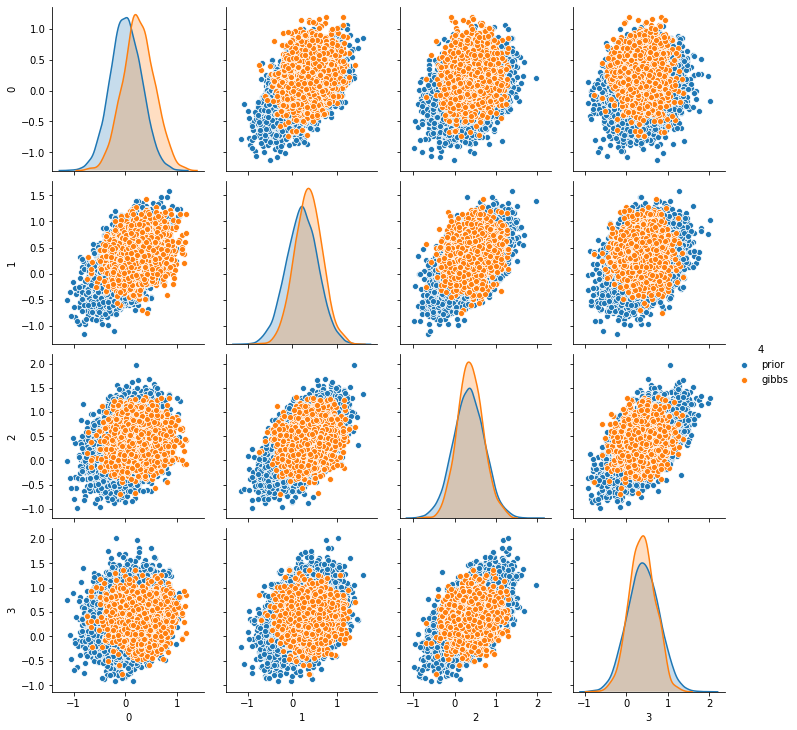

In [216]:
#Pairwise Plots of Gewecke Results
x_samples = x_samples[:,:,0,0]
print(x_samples.shape)
xpreds = xpreds[:,:,0,0]
print(xpreds.shape)


df = pd.DataFrame(xpreds[:,1:])
col = ['prior']*prior_iters
df[T-1]= col

df2 = pd.DataFrame(x_samples[:,1:])
col = ['gibbs']*(num_iters-burn_iters)
df2[T-1] = col 

df3 = df.append(df2)

sns.pairplot(df3, hue=T-1, diag_kind='kde')

(2000, 5)
(10000, 5)


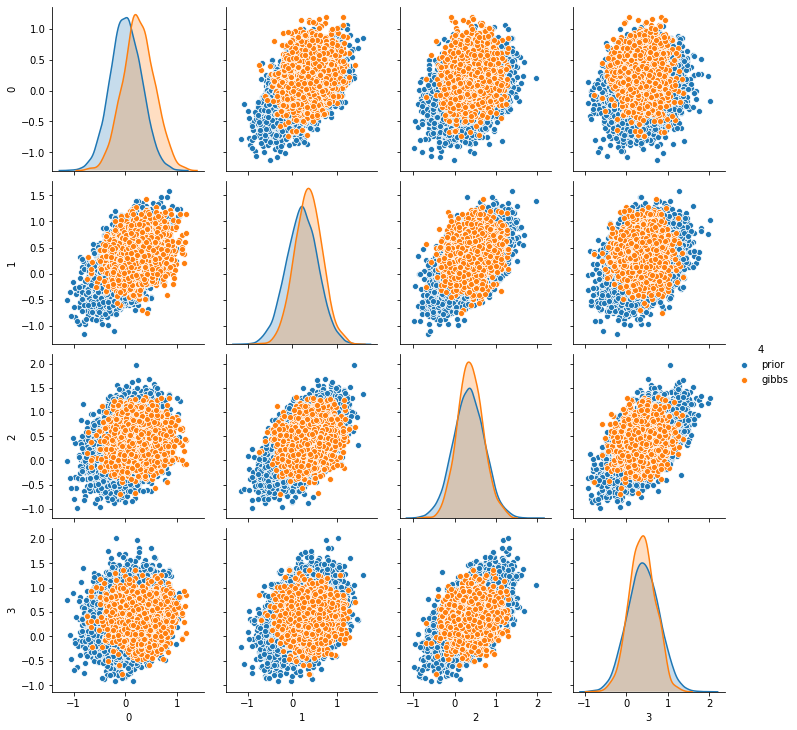

In [200]:
#Pairwise Plots of Gewecke Results
x_samples = x_samples[:,:,0,0]
print(x_samples.shape)
xpreds = xpreds[:,:,0,0]
print(xpreds.shape)


df = pd.DataFrame(xpreds[:,1:])
col = ['prior']*prior_iters
df[T-1]= col

df2 = pd.DataFrame(x_samples[:,1:])
col = ['gibbs']*(num_iters-burn_iters)
df2[T-1] = col 

df3 = df.append(df2)

sns.pairplot(df3, hue=T-1, diag_kind='kde')

(600000, 5)
(1000000, 5)


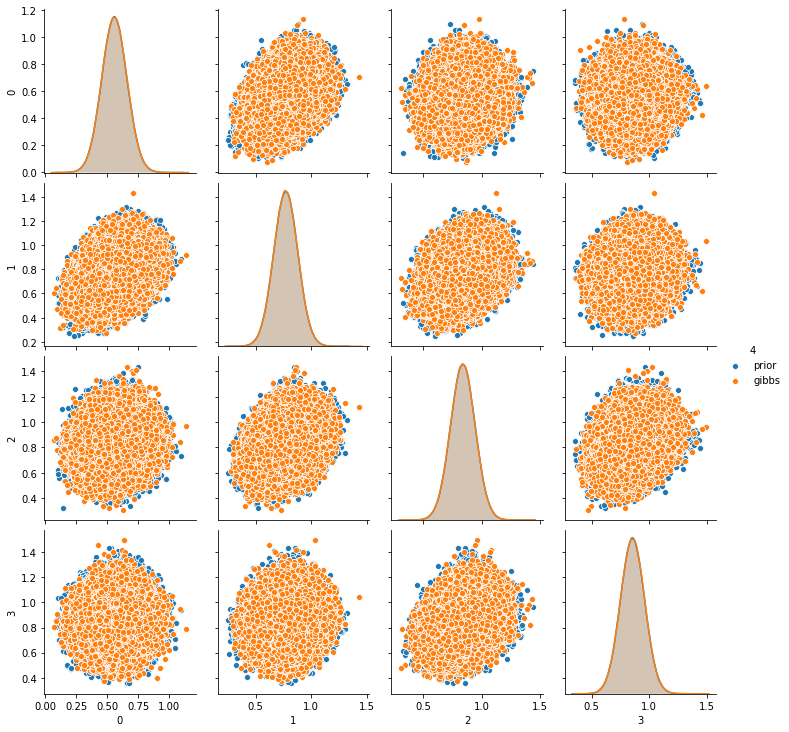

In [68]:
#Pairwise Plots of Gewecke Results Weights froze
x_samples = x_samples[:,:,0,0]
print(x_samples.shape)
xpreds = xpreds[:,:,0,0]
print(xpreds.shape)


df = pd.DataFrame(xpreds[:,1:])
col = ['prior']*prior_iters
df[T-1]= col

df2 = pd.DataFrame(x_samples[:,1:])
col = ['gibbs']*(num_iters-burn_iters)
df2[T-1] = col 

df3 = df.append(df2)

sns.pairplot(df3, hue=T-1, diag_kind='kde')